# Homework 4

**Name:**

In [2]:
Name = "Benson Riley"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

**A-Number:**

In [3]:
A_number = "A02327076"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

**Kaggle-UserName:**

In [4]:
Kaggle_UserName = "bensonriley"
assert Kaggle_UserName != "", 'Please enter your Kaggle Username in the above quotation marks, thanks!'

**Please describe your improvements here**:

*

*



In this homework, we will train a CNN model to classify big cats. This dataset consists of images of ten types of big cats, a.k.a, multiclass classification.

 **Please download the dataset from the [inclass Kaggle competition](https://www.kaggle.com/t/e5a7bab3f6c543a9943b3d9970768eaa) as we split the original dataset into the train-valid-test sets.**

This notebook contains a baseline model. Please use it as a starting point. **The purpose of this homework is to design an advanced CNN model to achieve better performance by yourself. You are not allowed to import pre-trained models. In case you are interested, we provide a sample code by using a pre-trained model, Resnet50.**

Your jobs

-   Read, complete, and run the code.

-   **Make substantial improvements** to maximize the accurcy.

-   Submit the .IPYNB file to Canvas.

    - Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
    
    - Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
    
    - Please keep your notebook clean and delete any throwaway code.

-   Submit the generated "pred.csv" to the [inclass Kaggle competition](https://www.kaggle.com/t/e5a7bab3f6c543a9943b3d9970768eaa).


# **Rules**

- You should finish your homework on your own.
- **You should not modify your prediction files manually.**
- Do not share code or prediction files with any living creatures.
- **Do not search or use additional data.**
- **Do not use any pre-trained models.**
    - You can ask Github copilot for help.


## Hints to Improve Your Results

* You'd better use a GPU machine to run it, otherwise it'll be quite slow.
* Revise the simple CNN model
* Revise the *transforms* function by using some image augumentation techniques
* Tune hyper-parameters, such as batch_size

First, import the packages or modules required for the competition.

In [5]:
import os
import pandas as pd
import shutil
import time
from copy import deepcopy

device = 'cuda'
import torchvision.models as models

In [6]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

### Download the dataset to Colab from Kaggle.

**You need to have your Kaggle Token at hand**. Please find [this article](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) for details.

In [8]:
from google.colab import files
files.upload(kaggle.json)   ## Upload your Kaggle token file.

ModuleNotFoundError: No module named 'google.colab'

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c fall2023-cs5665-hw4   ## You need to join the competition first.

 98% 65.0M/66.1M [00:03<00:00, 28.7MB/s]
100% 66.1M/66.1M [00:03<00:00, 19.5MB/s]


In [10]:
import os
import zipfile
from pathlib import Path
local_zip = 'fall2023-cs5665-hw4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

### Loading and normalizing

Using torchvision, it’s extremely easy to load the dataset.

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train images: 2111, val images: 50, test images: 278
trainset = torchvision.datasets.ImageFolder(root='./Dataset/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='./Dataset/val', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./Dataset/test', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = (os.listdir('./Dataset/train/'))
# print(trainloader.class_to_idx)

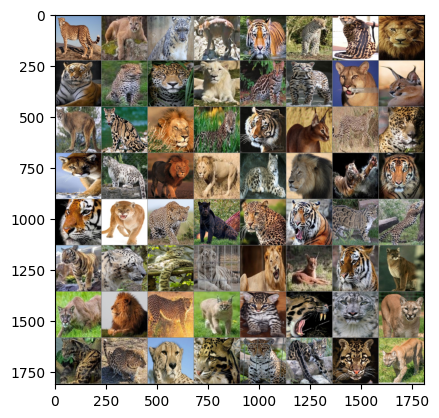

CHEETAH  PUMA CARACAL  PUMA


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

## Define the Training Functions

We will select the model and tune hyper-parameters according to the model's performance on the validation set. Next, we define the model training function `train`. We record the training time of each epoch, which helps us compare the time costs of different models.

In [15]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(20):
    net.train()
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")

    correct = 0
    net.eval()
    with torch.no_grad():
        for inputs,labels in valloader:
            out = net(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(net.state_dict())
    lr_scheduler.step()

print('Finished Training')

Train loss 1: 2.0723037310315218,Train Acc:21.60113690194221%
Val accuracy:40.0%
Train loss 2: 1.5604222635136347,Train Acc:44.71814306016106%
Val accuracy:44.0%
Train loss 3: 1.4422955717423809,Train Acc:49.73945997157745%
Val accuracy:44.0%
Train loss 4: 1.4316377894452599,Train Acc:50.213169114163904%
Val accuracy:44.0%
Train loss 5: 1.4305914947061615,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 6: 1.4304851530175364,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 7: 1.4304760038316222,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 8: 1.430475427323978,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 9: 1.430475476735692,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 10: 1.4304754688298178,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 11: 1.4304754472016046,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 12: 1.4304754863921527,Train Acc:50.35528185693984%
Val accuracy:44.0%
Train loss 13: 1.430475457

In [16]:
%%time
preds = []
net.load_state_dict(best_val_model)
net.eval()
with torch.no_grad():
    for inputs,labels in testloader:
        out = net(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        preds.append(out.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

CPU times: user 90.7 ms, sys: 68.5 ms, total: 159 ms
Wall time: 588 ms


In [17]:
import csv
with open('pred.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'label'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])